## import packages

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## remove stopwords
## we will replace this word list with our own list

In [1]:
#Prepare Stopwords
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','na', 'la', 'ooh', 'oh', 'ah', 'ba', 'da', 'aye','be',
                 'go','get','know','s'])

## import data

In [3]:
# Import Dataset
df = pd.read_csv('cleaned_data/combined_dataset.csv',sep=',')
df

,Year,text,tag,len
0,2001,im desperate changing starving truth im closer...,lyrics,135
1,2001,keep fallin love sometimes love ya sometimes m...,lyrics,87
2,2001,girls party look body shakin thing like never ...,lyrics,310
3,2001,back atmosphere drops jupiter hair hey acts li...,lyrics,186
4,2001,called phone said im comin hope alone cause go...,lyrics,225
...,...,...,...,...
2927,2015,article discusses former us government agency ...,news,51
2928,2015,obituary physician howard w jones jr noted wor...,news,11
2929,2015,article discusses wisconsin governor scott wal...,news,39
2930,2015,article announces million people impacted hack...,news,35


In [4]:
# Convert to list
data = df.text.values.tolist()
#pprint(data[:1])

Tokenize words and Clean-up text
- tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
- Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words[:1])

Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.
- Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. 
- The higher the values of these param, the harder it is for words to be combined to bigrams.

In [6]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

Remove Stopwords, Make Bigrams and Lemmatize
- define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
#print(stop_words)
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB','ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
print(type(data_words))
print(len(data_words))

<class 'list'>
2932


In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ','ADV','VERB'])

#print(data_lemmatized[:1])

Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

View a human-readable form of the corpus itself

In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('be', 16),
  ('change', 3),
  ('chase', 2),
  ('closer', 2),
  ('completely', 1),
  ('desperate', 2),
  ('else', 3),
  ('elseim', 1),
  ('even', 3),
  ('fall', 3),
  ('fly', 1),
  ('hanging_moment', 6),
  ('have', 3),
  ('ill', 1),
  ('incomplete', 1),
  ('invitation', 1),
  ('lack', 1),
  ('leave', 1),
  ('let', 3),
  ('lose', 1),
  ('love', 3),
  ('make', 3),
  ('menow', 1),
  ('mind', 1),
  ('move', 3),
  ('quite', 2),
  ('run', 2),
  ('s', 1),
  ('stand', 3),
  ('start', 2),
  ('starve', 2),
  ('sure', 2),
  ('take', 2),
  ('thing', 2),
  ('truth', 2),
  ('tune', 2),
  ('world', 1),
  ('would', 2),
  ('youforgette', 1),
  ('youim', 2),
  ('youjust', 1)]]

In addition to the corpus and dictionary, you need to provide the number of topics.

- Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

- chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.050*"let" + 0.036*"area" + 0.026*"dance" + 0.025*"continue" + '
  '0.022*"possibility" + 0.020*"body" + 0.017*"decide" + 0.016*"aid" + '
  '0.014*"form" + 0.008*"floor"'),
 (1,
  '0.031*"international" + 0.024*"expect" + 0.022*"rock" + 0.018*"appeal" + '
  '0.016*"position" + 0.012*"file" + 0.011*"storm" + 0.008*"react" + '
  '0.007*"gather" + 0.007*"powerful"'),
 (2,
  '0.025*"be" + 0.016*"say" + 0.011*"well" + 0.010*"take" + 0.010*"get" + '
  '0.009*"political" + 0.009*"give" + 0.008*"come" + 0.007*"call" + '
  '0.007*"american"'),
 (3,
  '0.061*"include" + 0.056*"government" + 0.049*"effort" + 0.026*"leader" + '
  '0.024*"topics_addresse" + 0.020*"police" + 0.017*"concern" + '
  '0.015*"provide" + 0.014*"follow" + 0.013*"criticism"'),
 (4,
  '0.029*"information" + 0.024*"reach" + 0.023*"run" + 0.021*"trial" + '
  '0.021*"television" + 0.015*"experience" + 0.015*"escape" + 0.014*"agree" + '
  '0.014*"relationship" + 0.013*"serve"'),
 (5,
  '0.025*"include" + 0.018*"state" +

Compute Model Perplexity and Coherence Score
- Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 
- a quick explanation: https://rare-technologies.com/what-is-topic-coherence/
- a paper: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.083203961269517

Coherence Score:  0.4626386383971111


In [17]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,mds='mmds')
# vis


Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

- A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

- A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

- if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

- Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. 

In [16]:
# Building LDA Mallet Model
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './mallet-2.0.8/bin/mallet'# update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('good', 0.07929588345657212),
   ('bad', 0.034764374793069194),
   ('light', 0.03195011588124931),
   ('head', 0.03095684803001876),
   ('place', 0.019258360004414523),
   ('back', 0.018154729058602805),
   ('start', 0.013409115991612404),
   ('turn', 0.01208475885663834),
   ('slow', 0.01180885112018541),
   ('round', 0.010594857079792517)]),
 (1,
  [('call', 0.045488165680473376),
   ('man', 0.04490701606086221),
   ('leave', 0.03222738799661876),
   ('home', 0.028265004226542687),
   ('friend', 0.02694420963651733),
   ('wait', 0.025834742180896028),
   ('back', 0.02197802197802198),
   ('long', 0.021608199492814877),
   ('talk', 0.02118554522400676),
   ('hear', 0.018808114961961116)]),
 (2,
  [('girl', 0.12398412398412398),
   ('put', 0.04512379512379512),
   ('hand', 0.03931203931203931),
   ('turn', 0.034303534303534305),
   ('move', 0.03345303345303345),
   ('stop', 0.03340578340578341),
   ('bring', 0.023766773766773767),
   ('play', 0.02145152145152145),
   ('low', 0

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps, here we choose the model with 20 topics (exactlt what we have gotten).

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=15, step=5)

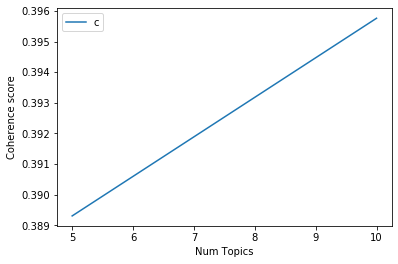

In [22]:
# Show graph
limit=15; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3893
Num Topics = 10  has Coherence Value of 0.3958


Below are the topics for the chosen LDA model.

In [27]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.026*"make" + 0.026*"back" + 0.024*"body" + 0.023*"hand" + 0.022*"bring" + '
  '0.021*"hit" + 0.021*"hot" + 0.019*"low" + 0.019*"give" + 0.019*"fuck"'),
 (1,
  '0.041*"find" + 0.035*"feel" + 0.028*"fall" + 0.028*"hold" + 0.027*"lose" + '
  '0.023*"stay" + 0.020*"lie" + 0.018*"place" + 0.018*"mind" + 0.016*"face"'),
 (2,
  '0.053*"turn" + 0.036*"break" + 0.032*"light" + 0.029*"head" + '
  '0.021*"people" + 0.020*"stop" + 0.020*"heart" + 0.019*"leave" + '
  '0.018*"play" + 0.017*"side"'),
 (3,
  '0.020*"report" + 0.013*"government" + 0.012*"year" + 0.010*"official" + '
  '0.009*"country" + 0.008*"american" + 0.008*"case" + 0.008*"lead" + '
  '0.007*"attack" + 0.007*"military"'),
 (4,
  '0.050*"boy" + 0.035*"put" + 0.027*"walk" + 0.027*"big" + 0.026*"rock" + '
  '0.023*"hard" + 0.023*"fly" + 0.022*"watch" + 0.016*"beat" + 0.015*"high"'),
 (5,
  '0.125*"girl" + 0.044*"man" + 0.030*"call" + 0.030*"bad" + 0.029*"real" + '
  '0.024*"money" + 0.020*"work" + 0.018*"show" + 0.016*"ride"

Finding the dominant topic in each sentence
- One of the practical application of topic modeling is to determine what topic a given document is about.

- To find that, we find the topic number that has the highest percentage contribution in that document.

- The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [30]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.2274,"good, night, life, move, tonight, feel, run, l...",im desperate changing starving truth im closer...
1,1,7.0,0.2997,"love, baby, make, ill, give, heart, feel, worl...",keep fallin love sometimes love ya sometimes m...
2,2,8.0,0.3047,"good, night, life, move, tonight, feel, run, l...",girls party look body shakin thing like never ...
3,3,6.0,0.2001,"time, thing, back, day, long, home, leave, hea...",back atmosphere drops jupiter hair hey acts li...
4,4,5.0,0.3530,"girl, man, call, bad, real, money, work, show,...",called phone said im comin hope alone cause go...
5,5,6.0,0.2439,"time, thing, back, day, long, home, leave, hea...",think ive already lost think already gone thin...
6,6,0.0,0.2385,"make, back, body, hand, bring, hit, hot, low, ...",uh uh uh huh yo yodrop glasses shake asses fac...
7,7,8.0,0.1958,"good, night, life, move, tonight, feel, run, l...",teas gone cold im wondering got bed morning ra...
8,8,7.0,0.2494,"love, baby, make, ill, give, heart, feel, worl...",ive searching heard cry within soul ive never ...
9,9,5.0,0.3986,"girl, man, call, bad, real, money, work, show,...",lucy liu girl drew cameron destiny charlies an...


In [33]:
df_dominant_topic.tail(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
2922,2922,3.0,0.2469,"report, government, year, official, country, a...",article discusses effects airstrikes yemen sau...
2923,2923,9.0,0.4000,"include, article_discusse, state, effort, plan...",article discusses us president barack obamas p...
2924,2924,9.0,0.2741,"include, article_discusse, state, effort, plan...",article discusses lack meeting time available ...
2925,2925,9.0,0.2450,"include, article_discusse, state, effort, plan...",article discusses us financing americantrained...
2926,2926,9.0,0.3530,"include, article_discusse, state, effort, plan...",article discusses lotteries subsidized housing...
2927,2927,9.0,0.1847,"include, article_discusse, state, effort, plan...",article discusses former us government agency ...
2928,2928,3.0,0.1250,"report, government, year, official, country, a...",obituary physician howard w jones jr noted wor...
2929,2929,9.0,0.3766,"include, article_discusse, state, effort, plan...",article discusses wisconsin governor scott wal...
2930,2930,3.0,0.2442,"report, government, year, official, country, a...",article announces million people impacted hack...
2931,2931,9.0,0.1774,"include, article_discusse, state, effort, plan...",article discusses eulogy delivered us presiden...


In [55]:
df_dominant_topic['Year']=df["Year"]
df_dominant_topic['Tag']=df["tag"]
#df_merge_col = pd.merge(df_dominant_topic, df, left_on='Text',right_on='text',how='left')

In [56]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Year,Tag
0,0,8.0,0.2274,"good, night, life, move, tonight, feel, run, l...",im desperate changing starving truth im closer...,2001,lyrics
1,1,7.0,0.2997,"love, baby, make, ill, give, heart, feel, worl...",keep fallin love sometimes love ya sometimes m...,2001,lyrics
2,2,8.0,0.3047,"good, night, life, move, tonight, feel, run, l...",girls party look body shakin thing like never ...,2001,lyrics
3,3,6.0,0.2001,"time, thing, back, day, long, home, leave, hea...",back atmosphere drops jupiter hair hey acts li...,2001,lyrics
4,4,5.0,0.3530,"girl, man, call, bad, real, money, work, show,...",called phone said im comin hope alone cause go...,2001,lyrics
...,...,...,...,...,...,...,...
2927,2927,9.0,0.1847,"include, article_discusse, state, effort, plan...",article discusses former us government agency ...,2015,news
2928,2928,3.0,0.1250,"report, government, year, official, country, a...",obituary physician howard w jones jr noted wor...,2015,news
2929,2929,9.0,0.3766,"include, article_discusse, state, effort, plan...",article discusses wisconsin governor scott wal...,2015,news
2930,2930,3.0,0.2442,"report, government, year, official, country, a...",article announces million people impacted hack...,2015,news


In [57]:
df_dominant_topic.to_csv('dominant_topic_combined_10_topics.csv')

Find the most representative document for each topic
- Sometimes just the topic keywords may not be enough to make sense of what a topic is about. 
- To help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [58]:
#Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6493,"make, back, body, hand, bring, hit, hot, low, ...",ok ok ok ok ok ok sean paul lil john jbo young...
1,1.0,0.5012,"find, feel, fall, hold, lose, stay, lie, place...",unwritten cant read mind im undefined im begin...
2,2.0,0.6257,"turn, break, light, head, people, stop, heart,...",stay late got nothing brain thats people say m...
3,3.0,0.4545,"report, government, year, official, country, a...",reports weeks baghdad iraq fell april looters ...
4,4.0,0.7264,"boy, put, walk, big, rock, hard, fly, watch, b...",aynow walk walk walk walk walk walk walk west ...


Topic distribution across documents
- To understand the volume and distribution of topics in order to judge how widely it was discussed. 
- The below table exposes that information.

In [59]:
#Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,8.0,"good, night, life, move, tonight, feel, run, l...",201.0,0.0686
1.0,7.0,"love, baby, make, ill, give, heart, feel, worl...",234.0,0.0798
2.0,8.0,"good, night, life, move, tonight, feel, run, l...",162.0,0.0553
3.0,6.0,"time, thing, back, day, long, home, leave, hea...",691.0,0.2357
4.0,5.0,"girl, man, call, bad, real, money, work, show,...",127.0,0.0433
...,...,...,...,...
2927.0,9.0,"include, article_discusse, state, effort, plan...",NaN,NaN
2928.0,3.0,"report, government, year, official, country, a...",NaN,NaN
2929.0,9.0,"include, article_discusse, state, effort, plan...",NaN,NaN
2930.0,3.0,"report, government, year, official, country, a...",NaN,NaN
